# CNN analysis of pooling indexes
This analyzes is dependent on what is defined within the network class. Meaning what area of the input is extracted is defined within the network class. This is suboptimal, but works for now. Dont exectute code cells that you are not trying to alter


### Load Libraries

In [45]:
import sys
SRC_DIR = "/Users/christianjohansen/Desktop/speciale/modeling/src"
sys.path.append(SRC_DIR)

import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from cdr_network import CdrCNN
import string

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

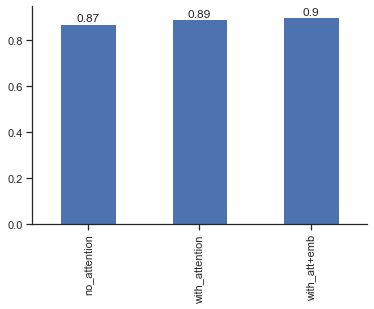

In [3]:
ax = pd.Series({"no_attention":0.87, "with_attention" : 0.89, "with_att+emb" : 0.9}).plot.bar()
for container in ax.containers:
    ax.bar_label(container)

In [217]:
def count_position_occurences(df, seq_len, activation, kernelsize=3, weight=1, cutoff=-np.inf):
    """
    First count number of occurences of a specific value in the columns of the df and sum over all columns
    Then returns these counts as they are (starting position), for all filter hits by adding to the count
    for every position in the filter selected by maxpooling.
    """
    labels = ["pad_before"] + [f"{i}" for i in range(1, seq_len+1)] + ["pad_after"]

    start_pos = np.zeros(len(labels))
    all_pos = np.zeros(len(labels))
    for i, col in enumerate(df.columns):
        for index, val in df[col].items():
            if activation.loc[index, col] > cutoff:
                start_pos[val] += 1
                for j in range(kernelsize):
                    all_pos[val + j] += 1

    starting_pos = pd.Series(start_pos, index=labels)
    filter_count = pd.Series(all_pos, index=labels)
    return pd.DataFrame([starting_pos, filter_count], index=["start_positions", "all_positions"])

def count_position_occurences_weighted(df, seq_len, activation, weight,  kernelsize=3, cutoff=-np.inf):
    """
    First count number of occurences of a specific value in the columns of the df and sum over all columns
    Then returns these counts as they are (starting position), for all filter hits by adding to the count
    for every position in the filter selected by maxpooling.
    """
    labels = ["pad_before"] + [f"{i}" for i in range(1, seq_len+1)] + ["pad_after"]

    start_pos = np.zeros(len(labels))
    all_pos = np.zeros(len(labels))
    for i, col in enumerate(df.columns):
        for index, val in df[col].items():
            if activation.loc[index, col] > cutoff:
                start_pos[val] += 1
                for j in range(kernelsize):
                    all_pos[val + j] += weight[i, j]

    starting_pos = pd.Series(start_pos, index=labels)
    filter_count = pd.Series(all_pos, index=labels)
    return pd.DataFrame([starting_pos, filter_count], index=["start_positions", "all_positions"])

def make_plot(df, df2, df3, df4, title1="", title2="", size=(8,6), file=None):
    """
    Makes simple bar plots of all filter positions and start positions
    """
    fig, axs = plt.subplots(2,2,figsize=size)
    x = np.arange(len(df.columns)) # positions of bars and ticks
    width = 0.35  # the width of the bars
    rects1 = axs[0,0].bar(x - width/2, df.loc["all_positions"], width)
    axs[0,0].set_xticks(x - width/2, df.columns, rotation=90)
    #axs[0,0].set_title(title1)
    
    rects1 = axs[0,1].bar(x - width/2, df2.loc["all_positions"], width)
    axs[0,1].set_xticks(x - width/2, df2.columns, rotation=90)
    #axs[1].set_title(title2)


    rects1 = axs[1,0].bar(x - width/2, df3.loc["all_positions"], width)
    axs[1,0].set_xticks(x - width/2, df3.columns, rotation=90)
    #axs[1,1].set_title(title2)

    rects1 = axs[1,1].bar(x - width/2, df4.loc["all_positions"], width)
    axs[1,1].set_xticks(x - width/2, df4.columns, rotation=90)
    #axs[1,0].set_title(title2)
    num = 1
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):

            axs[i, j].text(-0.1, 1.1, str(num), transform=axs[i, j].transAxes, 
                    size=16, weight='bold')
            num += 1
    plt.tight_layout()

    if file is not None:
        plt.savefig(file, dpi=300)
    
    plt.show()  
def calc_weights(weights: torch.Tensor):
    """
    Calculate position specific weights for the filter by taking the standard deviation for each position
    """
    return np.std(weights.detach().numpy(),1) #axis 1 is in channels (peptide encoding)


In [56]:
DIR = "/Users/christianjohansen/Desktop/speciale/modeling/"
ATTENTION_FILE = os.path.join(DIR, "results/cnn_att_partition5.csv")
ACTIVATION_FILE = os.path.join(DIR, "results/cnn_act_partition5.csv")
MODEL_PATH = os.path.join(DIR, "data/models/test_model.pt")

# Model parameters
cnn_channels = 20
hidden_neurons = 64
dropout = 0.3
cnn_kernel = 3

local_features = np.arange(20)
global_features = None
use_global_features = False
use_all_cdrs = False

## Load Data

In [149]:
data = pd.read_csv(ATTENTION_FILE)
activation = pd.read_csv(ACTIVATION_FILE)

columns_to_drop = data.columns[data.columns.str.endswith('_start')].tolist()
data = data.drop(columns_to_drop, axis=1)
activation = activation.drop(columns_to_drop, axis=1)

data.head()
pos_data = data[data.label == 1]
neg_data = data[data.origin == "10x"]
pos_data.shape, neg_data.shape

((352, 83), (670, 83))

## Load Model
Model is loaded to access the weights stored in saved model. These are used for calculating weights for the counting.

In [5]:
net = CdrCNN(local_features, global_features, use_global_features,
             cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel,
             dense_neurons=hidden_neurons, use_all_cdrs=use_all_cdrs)
net.load_state_dict(torch.load(MODEL_PATH))

RuntimeError: Error(s) in loading state_dict for CdrCNN:
	Missing key(s) in state_dict: "mhc_conv.weight", "mhc_conv.bias". 
	size mismatch for cdr3a_conv.weight: copying a param with shape torch.Size([20, 27, 3]) from checkpoint, the shape in current model is torch.Size([20, 20, 3]).
	size mismatch for cdr3b_conv.weight: copying a param with shape torch.Size([20, 27, 3]) from checkpoint, the shape in current model is torch.Size([20, 20, 3]).
	size mismatch for pep_conv.weight: copying a param with shape torch.Size([20, 27, 3]) from checkpoint, the shape in current model is torch.Size([20, 20, 3]).
	size mismatch for dense1.weight: copying a param with shape torch.Size([64, 87]) from checkpoint, the shape in current model is torch.Size([64, 80]).
	size mismatch for bn_dense.weight: copying a param with shape torch.Size([87]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for bn_dense.bias: copying a param with shape torch.Size([87]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for bn_dense.running_mean: copying a param with shape torch.Size([87]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for bn_dense.running_var: copying a param with shape torch.Size([87]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for bn_start.weight: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for bn_start.bias: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for bn_start.running_mean: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for bn_start.running_var: copying a param with shape torch.Size([27]) from checkpoint, the shape in current model is torch.Size([20]).

Data contains the entire dataset, with added columns as shown above. These columns corresponds to filters from the CNN, and the values are what position the first position of the filter hit

In [6]:
peptides = data["pep"].value_counts()
peptides

GILGFVFTL    782
GLCTLVAML    225
NLVPMVATV    180
FLYALALLL     42
LLFGYPVYV     33
RTLNAWVKV     27
KTWGQYWQV     17
RMFPNAPYL     16
MLDLQPETT     14
SLLMWITQV      9
SLFNTVATL      8
YLLEMLWRL      7
IMDQVPFSV      7
KVLEYVIKV      3
CLGGLLTMV      2
KVAELVHFL      2
KLQCVDLHV      1
Name: pep, dtype: int64

Clearly the data is biased towards GIL peptide. Therefore we only investigate unique sequences for the peptides. But this should be kept in mind for any analysis, since most of these plots are summed over observations and therefore primarily represent the GIL peptide.

## Analysis of Max pooling indexes
The hyptothesis here is based on how the CNN and maxpooling would interact. The hope is that one filter learns specific things, that are important for each position in the peptide/cdrs. By looking at the max pooling indexes we can see what position contributes with information in the dense layer. 

I need to know the amount of peptides in each group since there is big imbalance, and since we are only looking at peptide first. All identical peptides would pool in the same manner.

### Unique peptide analysis
Count the number of times each position is selected when doing maxpooling. Done for only unique peptides here

In [7]:
peptide_indexes = [np.where(data == peptide)[0][0] for peptide in peptides.index]
unique_pep_data = data.loc[peptide_indexes, data.columns.str.startswith("pep_")]
length = 9
peptide_counts = count_position_occurences(unique_pep_data, length, activation=activation)

In [8]:
peptide_counts

,pad_before,1,2,3,4,5,6,7,8,9,pad_after
start_positions,34.0,43.0,30.0,47.0,38.0,47.0,41.0,30.0,30.0,0.0,0.0
all_positions,34.0,77.0,107.0,120.0,115.0,132.0,126.0,118.0,101.0,60.0,30.0


Total number of counts is $ n_{filters} \cdot n_{obs} \cdot kernelSize $ ($3 \cdot 16 \cdot 3 = 144$)

Doing the same analysis on a completely new network might show a different distribution of chosen positions

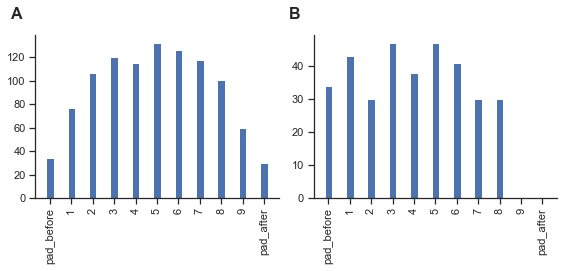

In [66]:
make_plot(peptide_counts, size=(8,4))

Keep in mind that more filters are overlapping with the middle positions, than the outlier positions. When looking at the possible filter positions that are possible.

The peptide cannot start with position 9 Since the kernel will only be 9 long. The filter starting at first pad and 8 cannot be chosen either, since they contain padding.

## CDR3b analysis

### General analysis of 1 TCR or all summed
This is more interesting for the TCRs where there are more unique TCRs, which could have similar binding motifs, and therefore similar "attentions" selected by the maxpooling

In [148]:
length = max(data["cdr3b"].str.len())
cdr3b_data = data.loc[:,data.columns.str.startswith("cdr3b_")]
cdr3b_all_counts = count_position_occurences(cdr3b_data, length, activation=activation)

,pep_1,pep_2,pep_3,pep_4,pep_5,pep_6,pep_7,pep_8,pep_9,pep_10,...,fa_elec,fa_dun,p_aa_pp,global_interactions,label,mhc,tcra,tcrb,origin,cdr3_len
0,1,3,5,3,2,3,7,4,2,0,...,"['0.0', '0.119', '1.564', '0.287', '1.458', '2...","['0.0', '-0.356', '-0.237', '-0.414', '0.253',...","['0.783', '-2.284', '-5.799', '-4.249', '-3.61...","['-6.86874', '8.52651e-14', '-0.238405', '-0.0...",0.0,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,VQEGEDFTTYCNSSTTLSNIQWYKQRPGGHPVFLIQLVKSGEVKKK...,GITQSPKYLFRKEGQNVTLSCEQNLNHDAMYWYRQVPGQGLRLIYY...,swapped_5979,25
1,5,6,7,4,3,6,5,7,7,5,...,"['0.0', '0.08', '1.667', '0.272', '2.121', '2....","['0.0', '-0.451', '-0.266', '-0.441', '0.165',...","['0.726', '-2.488', '-5.632', '-4.262', '-3.30...","['-5.52278', '-0.672687', '-0.421215', '-0.034...",0.0,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,QVEQSPPDLILQEGANSTLRCNFSDSVNNLQWFHQNPWGQLINLFY...,GVSQSPRYKVAKRGQDVALRCDPISGHVSLFWYQQALGQGPEFLTY...,10x,27
2,5,6,7,4,3,6,5,7,7,5,...,"['0.0', '0.079', '1.633', '0.14', '2.211', '3....","['0.0', '-0.463', '-0.263', '-0.498', '0.154',...","['0.558', '-2.425', '-6.047', '-4.373', '-3.77...","['-4.88548', '-0.0830153', '-1.50753', '-0.411...",0.0,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,QVKQSPQSLIVQKGGISIINCAYENTAFDYFPWYQQFPGKGPALLI...,AGVAQSPRYKIIEKRQSVAFWCNPISGHATLYWYQQILGQGPKLLI...,swapped_5740,26
3,2,1,5,1,0,1,2,6,0,1,...,"['0.0', '0.144', '1.544', '0.608', '1.465', '2...","['0.0', '-0.298', '-0.156', '0.163', '0.25', '...","['0.695', '-2.472', '-5.57', '-4.167', '-3.553...","['-5.08818', '-1.38081', '-0.483825', '0.0', '...",0.0,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,PQALSIQEGENATMNCSYKTSINNLQWYRQNSGRGLVHLILIRSNE...,ITQSPRHKITETGRQVTLACHQTWNHNNMFWYRQDLGHGLRLIHYS...,10x,25
4,5,6,7,4,3,6,5,7,7,5,...,"['0.0', '0.081', '1.767', '0.215', '1.963', '1...","['0.0', '-0.437', '-0.218', '-0.469', '0.103',...","['0.685', '-2.525', '-5.801', '-4.229', '-3.98...","['-5.3082', '-0.169591', '-0.941603', '0.0', '...",0.0,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,QVTQSPEALRLQEGESSSLNCSYTVSGLRGLFWYRQDPGKGPEFLF...,GITQSPKYLFRKEGQNVTLSCEQNLNHDAMYWYRQDPGQGLRLIYY...,10x,28


### Plot summed over all observations and filters CDR3b
To get a feeling for the general data we can also look at the entire collection of maxpooled positions

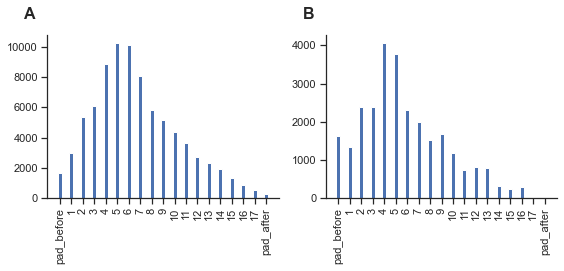

In [67]:
make_plot(cdr3b_all_counts,
         size=(8,4))

Only positions with high activations

In [12]:
cdr3b_high_counts = count_position_occurences(cdr3b_data, length, activation=activation, cutoff=0.9)

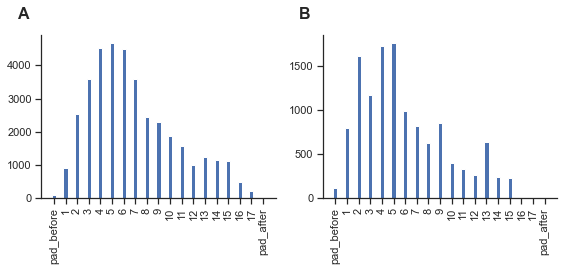

In [68]:
make_plot(cdr3b_high_counts,
         size=(8,4))

### CDR3b per peptide motif for maxpooling
Many motifs might be captured when summing over all observations. To investigate only a single peptide with a positive interaction for finding positions that are important for binding that peptide

Select peptide and cdr3 length from the list below

In [242]:
# 'GILGFVFTL', 'GLCTLVAML', 'NLVPMVATV', 'LLFGYPVYV', 'FLYALALLL',
# 'RTLNAWVKV', 'KTWGQYWQV', 'SLLMWITQV', 'RMFPNAPYL', 'YLLEMLWRL',
# 'MLDLQPETT', 'KVLEYVIKV', 'IMDQVPFSV', 'SLFNTVATL', 'KLQCVDLHV',
# 'CLGGLLTMV'
peptide = "GILGFVFTL"
cdr_length = 12 # what cdr length to choose
mask = (pos_data.pep == peptide) & (pos_data.cdr3b.str.len() == cdr_length)

cdr3b_peptide_data_pos = pos_data.loc[mask, pos_data.columns.str.startswith("cdr3b_")]


mask = (neg_data.pep == peptide) & (neg_data.cdr3b.str.len() == cdr_length)

cdr3b_peptide_data_neg = neg_data.loc[mask, neg_data.columns.str.startswith("cdr3b_")]


max_len = max(data.cdr3b.str.len()) # max length of a cdr3b for creating array
cdr3b_peptide_counts_pos = count_position_occurences(cdr3b_peptide_data_pos, max_len, activation)
cdr3b_peptide_counts_neg = count_position_occurences(cdr3b_peptide_data_neg, max_len, activation)

cdr3b_peptide_data_neg.shape, cdr3b_peptide_data_pos.shape

((84, 20), (177, 20))

### Plot of maxpooling positions for a specific length of cdr3b with a specific peptide

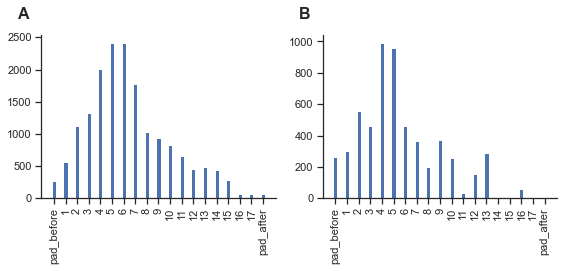

In [89]:
make_plot(cdr3b_peptide_counts_pos,
          size=(8,4))

Filters can store the important information in all 3 positions, but they are note necessarily equally important. To handle this issue the standard deviation is calculated for each position in each filter and added instead of the count. The standard deviation shows how specific a motif has to bee to be captured. Since important positions will have high weights for some residues, while low for others giving a high standard deviation. Compared with a motif with no preference this will have lower standard devation

In [90]:
''

''

In [91]:
cdr3b_filter_weights = calc_weights(net.cdr3b_conv.weight)
cdr3b_weighted_counts = count_position_occurences_weighted(cdr3b_peptide_data_pos, max_len, activation, weight=cdr3b_filter_weights)

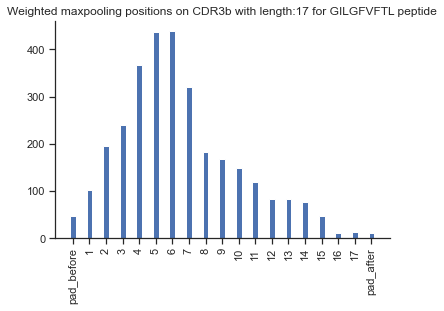

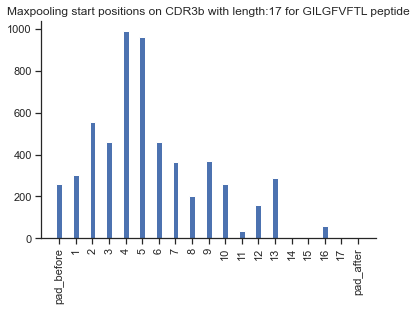

In [19]:
make_plot(cdr3b_weighted_counts,
          title1=f"Weighted maxpooling positions on CDR3b with length:{length} for {peptide} peptide",
          title2=f"Maxpooling start positions on CDR3b with length:{length} for {peptide} peptide")

Lastly you can also add information about the activation of the layer. Higher activation should be due to a more significant motif.

In [243]:
cdr3b_peptide_counts_high_pos = count_position_occurences(cdr3b_peptide_data_pos, max_len, activation, cutoff=0.97)
cdr3b_peptide_counts_high_neg = count_position_occurences(cdr3b_peptide_data_neg, max_len, activation, cutoff=0.97)

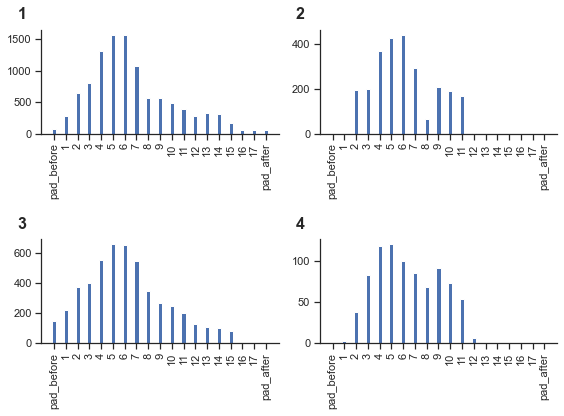

In [244]:
make_plot(cdr3b_peptide_counts_pos, cdr3b_peptide_counts_high_pos,
          cdr3b_peptide_counts_neg, cdr3b_peptide_counts_high_neg,
         size=(8,6), file="../../../../plots/maxpool_cdr3b_gil12.png")


## CDR3a analysis

In [142]:
length = max(data["cdr3a"].str.len())
cdr3a_data = data.loc[:,data.columns.str.startswith("cdr3a_")]
cdr3a_all_counts = count_position_occurences(cdr3a_data, length, activation)

### Plot showing for all filters and all positions

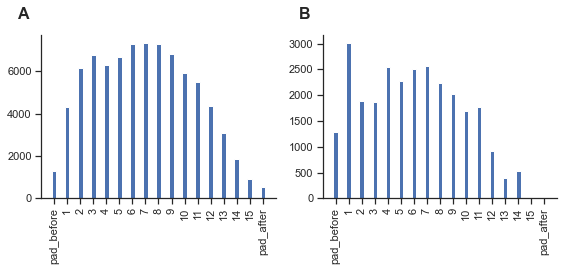

In [71]:
make_plot(cdr3a_all_counts,
          size=(8,4))

### Using only high activation

In [34]:
cdr3a_high_counts = count_position_occurences(data.loc[:,data.columns.str.startswith("cdr3a_")], length, activation, cutoff=0.9)

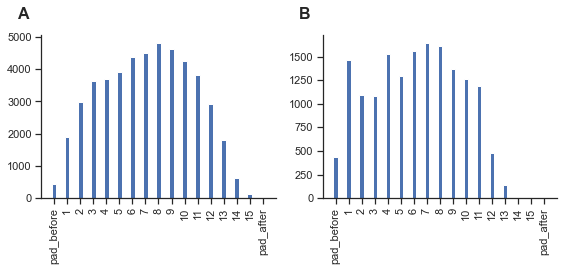

In [72]:
make_plot(cdr3a_high_counts,
          size=(8,4))

## CDR3a per peptide analysis
Only look at TCRs with known positive binding to specific peptides

In [238]:
# 'GILGFVFTL', 'GLCTLVAML', 'NLVPMVATV', 'LLFGYPVYV', 'FLYALALLL',
# 'RTLNAWVKV', 'KTWGQYWQV', 'SLLMWITQV', 'RMFPNAPYL', 'YLLEMLWRL',
# 'MLDLQPETT', 'KVLEYVIKV', 'IMDQVPFSV', 'SLFNTVATL', 'KLQCVDLHV',
# 'CLGGLLTMV'
peptide = "GILGFVFTL"
cdr_length = 12 # what cdr length to choose
mask = (data.pep == peptide) & (data.cdr3a.str.len() == cdr_length)
cdr3a_peptide_data_pos = data[data.label == 1]
cdr3a_peptide_data_neg = data[data.origin == "10x"]

cdr3a_peptide_data_pos = cdr3a_peptide_data_pos.loc[mask, cdr3a_peptide_data_pos.columns.str.startswith("cdr3a_")]
cdr3a_peptide_data_neg = cdr3a_peptide_data_neg.loc[mask, cdr3a_peptide_data_neg.columns.str.startswith("cdr3a_")]
cdr3a_peptide_data_pos.shape, cdr3a_peptide_data_neg.shape

((29, 20), (99, 20))

In [239]:
max_len = max(data.cdr3a.str.len()) # max length of a cdr3a for creating array
cdr3a_peptide_counts_pos = count_position_occurences(cdr3a_peptide_data_pos, max_len, activation)
cdr3a_peptide_counts_neg = count_position_occurences(cdr3a_peptide_data_neg, max_len, activation)

### Plots showing maxpooling positions summed over all filters for cdr3a for specific peptide

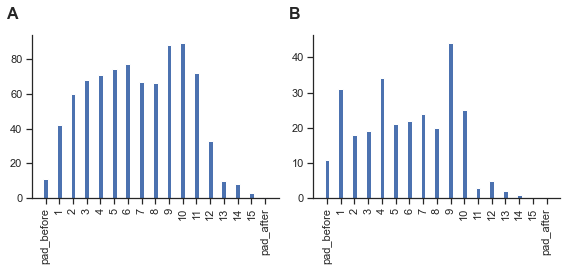

In [101]:
make_plot(cdr3a_peptide_counts,
          size=(8,4))

This can again be weighted by a position specific scoring

In [102]:
cdr3a_filter_weights = calc_weights(net.cdr3a_conv.weight)
cdr3a_weighted_counts = count_position_occurences_weighted(cdr3a_peptide_data, max_len, activation, weight=cdr3a_filter_weights)

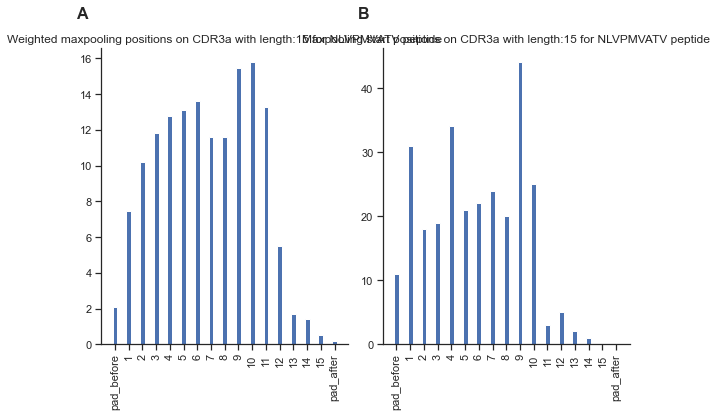

In [103]:
make_plot(cdr3a_weighted_counts,
          title1=f"Weighted maxpooling positions on CDR3a with length:{length} for {peptide} peptide",
          title2=f"Maxpooling start positions on CDR3a with length:{length} for {peptide} peptide")

Again we deselect any filters not having an activation above the cutoff

In [240]:
cdr3a_peptide_counts_high_pos = count_position_occurences(cdr3a_peptide_data_pos, max_len, activation, cutoff=0.95)
cdr3a_peptide_counts_high_neg = count_position_occurences(cdr3a_peptide_data_neg, max_len, activation, cutoff=0.95)


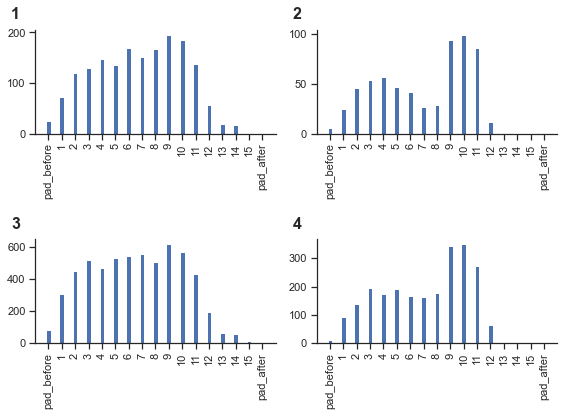

12 GILGFVFTL


In [241]:
make_plot(cdr3a_peptide_counts_pos, cdr3a_peptide_counts_high_pos,
          cdr3a_peptide_counts_neg, cdr3a_peptide_counts_high_neg,
          size=(8,6), file="../../../../plots/mapool_cdr3a_gil12.png")
print(cdr_length, peptide)

## Check results from CV experiment to see per peptide performance

For now only has the performance of the CDRs

In [ ]:
result = pd.read_csv("../results/cnn_all_scores.csv", header=None, names=["peptide", "origin", "score", "label"])
result.head()

,peptide,origin,score,label
0,GILGFVFTL,10x,0.087538,0.0
1,LLFGYPVYV,10x,0.550246,0.0
2,GILGFVFTL,positive,0.998128,1.0
3,GILGFVFTL,swapped_4548,0.136307,0.0
4,GILGFVFTL,10x,0.202343,0.0


In [ ]:
from sklearn import metrics
def calc_auc(x):
    d = {}
    d["auc"] = metrics.roc_auc_score(x["label"],x["score"])
    d["counts"] = len(x)
    return pd.Series(d, index=["auc", "counts"])

result = result[result["peptide"].isin(result["peptide"].value_counts(ascending=False).head(10).index)]
auc_df = result.groupby("peptide").apply(calc_auc)

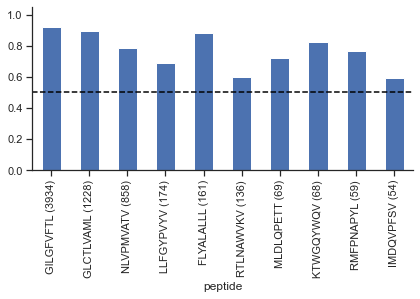

In [ ]:
def get_labels(x):
    return f"{x.name} ({int(x['counts'])})"

auc_df = auc_df.sort_values("counts",ascending=False)
ax = auc_df.plot.bar(y="auc",ylim=[0,1.05])
ax.axhline(0.5, ls="--", c="black")
plt.tight_layout()
ax.get_legend().remove()
ax.set_xticklabels(auc_df.apply(get_labels, axis=1))
plt.savefig("../results/cdr_peptide_auc.png")

In [ ]:
df = pd.DataFrame({"baseline" : [0.86, 0.84, 0.78, 0.8, 0.68, 0.75],
              "cdr3" : [0.88, 0.85, 0.79, 0.8, 0.65, 0.74],
              "all_cdrs" : [0.92, 0.91, 0.86, 0.87, 0.76, 0.77]},
              index=["1", "0.98", "0.95", "0.95,0.9", "0.9", "0.9,0.85"])

Text(0, 0.5, 'AUC')

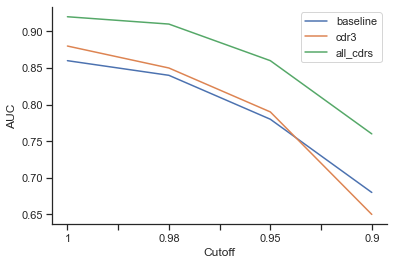

In [ ]:
ax = df.loc[["1", "0.98", "0.95", "0.9"]].plot(kind="line")
ax.set_xlabel("Cutoff")
ax.set_ylabel("AUC")